In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif, SelectKBest

from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV


In [ ]:
df = pd.read_csv('AB_NYC_2019.csv',delimiter = ',')

# **Exploratory Data Analysis & Feature Creation**

 **dealing with missing value and outlier**

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
# check missing values
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
# Check if all rows with NaN value in 'last_review' contains value 0 in 'number_of_reviews'
matching_rows_df = df[(df['number_of_reviews'] == 0) & (df['last_review'].isnull())]
if len(matching_rows_df) == df['last_review'].isnull().sum():
    print("All NaN rows in 'last_review' have the corresponding value 0 in the 'number_of_reviews'")
else:
    print("There are NaN rows without the corresponding value in the 'number_of_reviews'")

All NaN rows in 'last_review' have the corresponding value 0 in the 'number_of_reviews'


count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

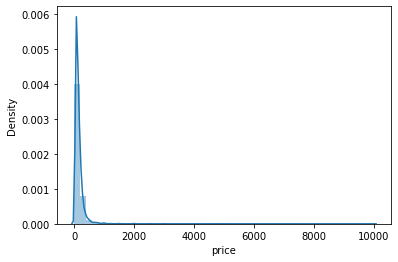

In [ ]:
print(df['price'].describe())
sns.distplot(df['price'])

In [ ]:
# drop the rows with price equal to 0
df1 = df[df['price'] != 0]
df1.reset_index(drop=True, inplace=True)


#drop the rows with price higher than the 95% quantile to reduce the impact of outliers.
print(df['price'].quantile(0.95))
print((df1['price'] >= df['price'].quantile(0.95)).sum())
df1 = df1[df1['price'] <= df['price'].quantile(0.95)]
df1.reset_index(drop=True, inplace=True)

df1.info()

355.0
2451
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46443 entries, 0 to 46442
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              46443 non-null  int64  
 1   name                            46428 non-null  object 
 2   host_id                         46443 non-null  int64  
 3   host_name                       46422 non-null  object 
 4   neighbourhood_group             46443 non-null  object 
 5   neighbourhood                   46443 non-null  object 
 6   latitude                        46443 non-null  float64
 7   longitude                       46443 non-null  float64
 8   room_type                       46443 non-null  object 
 9   price                           46443 non-null  int64  
 10  minimum_nights                  46443 non-null  int64  
 11  number_of_reviews               46443 non-null  int64  
 12  last_review          

In [ ]:
# to assign values to missing ones.
# df1['last_review'] = df1['last_review'].fillna('2020-01-01')
# df1['reviews_per_month'] = df1['reviews_per_month'].fillna(0)

# replace the missing data of reveiw_per_month with mean value
mean = df1['reviews_per_month'].mean()
df1['reviews_per_month'].fillna(mean, inplace=True)
df1.isnull().sum()

id                                   0
name                                15
host_id                              0
host_name                           21
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9186
reviews_per_month                    0
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [ ]:
df1.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.644300e+04,4.644300e+04,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000
mean,1.891941e+07,6.646223e+07,40.728576,-73.950978,122.612794,6.944297,23.823009,1.377333,6.686627,109.706264
std,1.093144e+07,7.769824e+07,0.055187,0.046383,71.971323,19.875539,45.184378,1.513927,31.131876,130.423905
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.445547e+06,7.719674e+06,40.689360,-73.982100,65.000000,1.000000,1.000000,0.270000,1.000000,0.000000
50%,1.954585e+07,3.034546e+07,40.722020,-73.954580,100.000000,2.000000,5.000000,1.190000,1.000000,40.000000
75%,2.893970e+07,1.056556e+08,40.763330,-73.934630,160.000000,5.000000,24.000000,1.610000,2.000000,218.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,355.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
# split data into Numerical data & Categorical data
def split_num_cat(data):
    num_data = data.select_dtypes(exclude=['object'])
    cat_data = data.select_dtypes(include=['object'])
    return num_data, cat_data

num, cat = split_num_cat(df1)
print(num.columns)
print(cat.columns)

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
Index(['name', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'last_review'],
      dtype='object')


 **numerical variables**

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

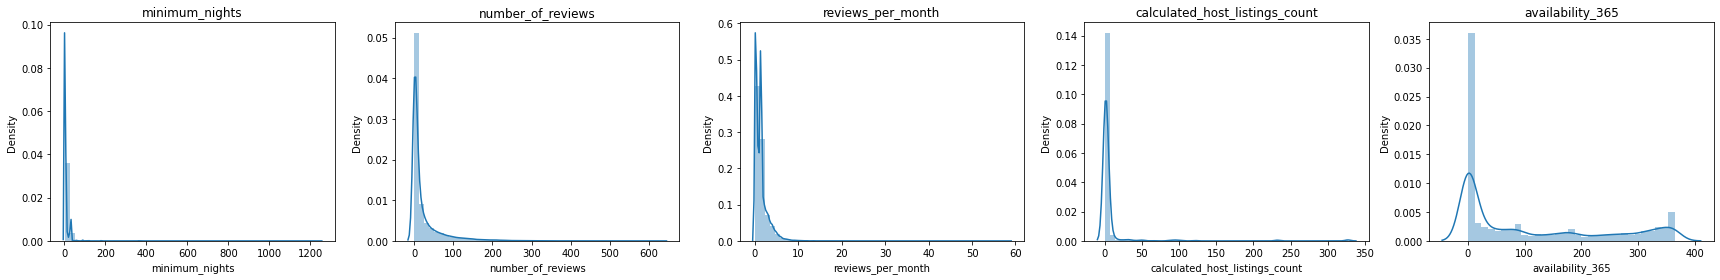

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000
mean,6.944297,23.823009,1.377333,6.686627,109.706264
std,19.875539,45.184378,1.513927,31.131876,130.423905
min,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.000000,1.000000,0.270000,1.000000,0.000000
50%,2.000000,5.000000,1.190000,1.000000,40.000000
75%,5.000000,24.000000,1.610000,2.000000,218.000000
max,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
# check the distribution of each numerical feature
cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(24, 4))
for i, col in enumerate(cols):
    sns.distplot(df1[col], ax=axes[i])
    axes[i].set_title(col)
# Show the plot
plt.tight_layout()
plt.show()

df1[cols].describe()

In [ ]:
print(df1['calculated_host_listings_count'].quantile(0.95))
print((df1['calculated_host_listings_count']>df1['calculated_host_listings_count'].quantile(0.95)).sum())
print(df1['reviews_per_month'].quantile(0.95))
print((df1['reviews_per_month']>df1['reviews_per_month'].quantile(0.95)).sum())

13.0
2315
4.35
2315


In [ ]:
# add two columns to reduce the impact of outliers in 'calculated_host_listings_count' & 'reviews_per_month'
df1['adj_calculated_host_listings_count'] = np.where(df1['calculated_host_listings_count'] > df1['calculated_host_listings_count'].quantile(0.95),\
                                        df1['calculated_host_listings_count'].quantile(0.95), df1['calculated_host_listings_count'])
df1['adj_reviews_per_month'] = np.where(df1['reviews_per_month'] > df1['reviews_per_month'].quantile(0.95),\
                                        df1['reviews_per_month'].quantile(0.95), df1['reviews_per_month'])


In [ ]:
# df1.head()
df1.shape

(46443, 18)

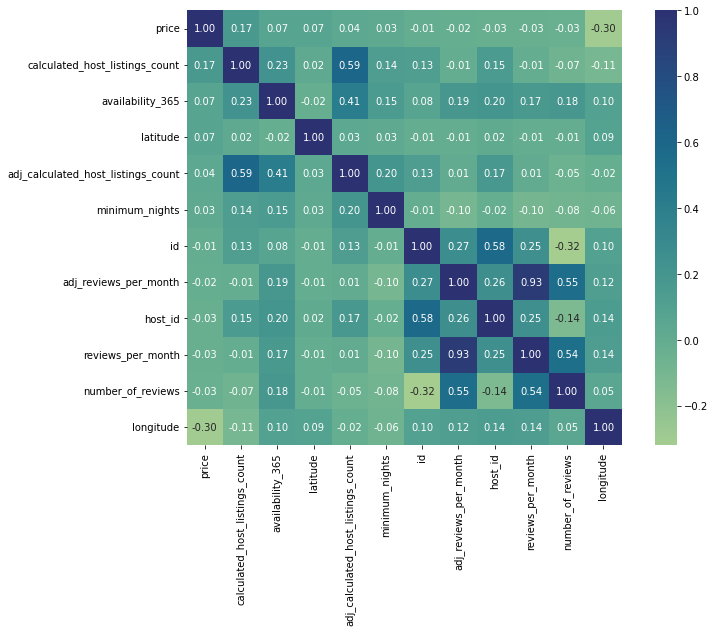

In [ ]:
# create the correlation heatmap

# checking for top variables in term of correlation with price
corr=df1.corr()
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'price')['price'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

 **categorical variables**

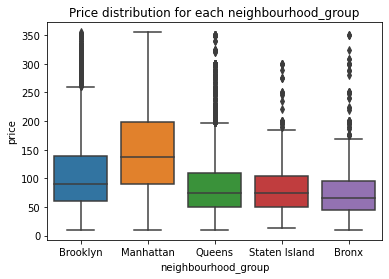

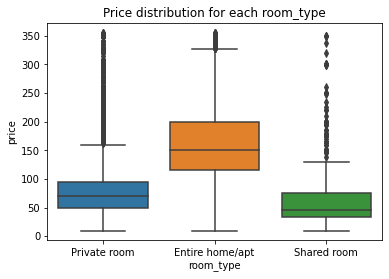

In [ ]:
# check the correlation between price and every categorical feature.

# price by neighbourhood_group
ax = sns.boxplot(data=df1, x='neighbourhood_group', y='price')
ax.set_title('Price distribution for each neighbourhood_group')
plt.show()

# price by room_type
ax = sns.boxplot(data=df1, x='room_type', y='price')
ax.set_title('Price distribution for each room_type')
plt.show()


2019    24108
2018     5825
2017     3118
2016     2603
2015     1337
2014      189
2013       46
2012       24
2011        7
Freq: A-DEC, Name: y_last_review, dtype: int64


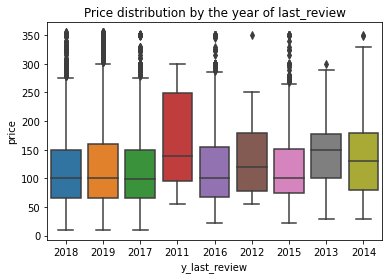

In [ ]:
# add two columns containing information about last_review in a yearly or yearly+monthly basis.
# I'm not sure how much does it work.

df1['y_m_last_review'] = pd.to_datetime(df1['last_review']).dt.to_period('M')
df1['y_last_review'] = pd.to_datetime(df1['last_review']).dt.to_period('Y')
print(df1['y_last_review'].value_counts().sort_index(ascending=False))

# price by y_last_review
ax = sns.boxplot(data=df1, x='y_last_review', y='price')
ax.set_title('Price distribution by the year of last_review')
plt.show()


In [ ]:
# # add a column combining the inforamtion of neighbourhood with neighbourhood_group -- abandaoned
# df1['adj_neighbourhood'] = df1['neighbourhood_group'].str.cat(df1['neighbourhood'], sep=' ')
# df1.head()

In [ ]:
df1['neighbourhood_group'].value_counts()

Manhattan        19868
Brooklyn         19552
Queens            5586
Bronx             1072
Staten Island      365
Name: neighbourhood_group, dtype: int64

In [ ]:
# using ANOVA to check the correlation of categorical features and our predictive variable(price)

model = sm.OLS.from_formula('price ~ C(neighbourhood)', data=df1).fit()
sm.stats.anova_lm(model, typ=2)

# we can see that adj_neighbourhood is an important categorical feature to some extent cuz the F-value is 8.3 with 0 p-value.

,sum_sq,df,F,PR(>F)
C(neighbourhood),5.976575e+07,218.0,70.092277,0.0
Residual,1.807978e+08,46224.0,NaN,NaN


In [ ]:
model2 = ols('price ~ C(neighbourhood_group)', data=df1).fit()
sm.stats.anova_lm(model2, typ=2)

# we can see that neighbourhood_group is a very important categorical feature cuz the F-value is very large with 0 p-value.

,sum_sq,df,F,PR(>F)
C(neighbourhood_group),2.750037e+07,4.0,1498.454477,0.0
Residual,2.130632e+08,46438.0,NaN,NaN


In [ ]:
model3 = ols('price ~ C(room_type)', data=df1).fit()
sm.stats.anova_lm(model3, typ=2)

# we can see that room type is a very important categorical feature cuz the F-value is very large with 0 p-value.

,sum_sq,df,F,PR(>F)
C(room_type),8.955348e+07,2.0,13770.149956,0.0
Residual,1.510101e+08,46440.0,NaN,NaN


In [ ]:
df1['y_last_review'] = df1['y_last_review'].astype(str)
df1['y_m_last_review'] = df1['y_m_last_review'].astype(str)

model4 = ols('price ~ y_last_review', data=df1).fit()
sm.stats.anova_lm(model4, typ=2)

,sum_sq,df,F,PR(>F)
y_last_review,1.215680e+06,9.0,26.204379,1.282525e-45
Residual,2.393479e+08,46433.0,NaN,NaN


In [ ]:
# trial: time gap since last_review: 
# now - last_review, to see if the gap is too large will decrease the price

# Feature Selection & Modeling

In [ ]:
# # features to choose
# selected_feature = ['adj_neighbourhood','latitude','room_type','minimum_nights',\
#                     'reviews_per_month','calculated_host_listings_count','availability_365','host_id']
# x_data = df1[selected_feature]
# y_data = df1[['price']]

# features to choose
selected_feature = ['neighbourhood_group','neighbourhood','latitude','longitude','number_of_reviews','room_type','minimum_nights',\
                    'reviews_per_month','calculated_host_listings_count','availability_365','host_id']
x_data = df1[selected_feature]
y_data = df1[['price']]


In [ ]:
# split training & test set
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(37154, 11) (9289, 11)
(37154, 1) (9289, 1)


In [ ]:
#define numerical and categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)
print(numerical_columns)
print(categorical_columns)

['latitude', 'longitude', 'number_of_reviews', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_id']
['neighbourhood_group', 'neighbourhood', 'room_type']


In [ ]:
#define preprocessor to all selected columns
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ('standard_scaler', StandardScaler(), numerical_columns)])

 **Decision Tree**

In [ ]:
model = make_pipeline(preprocessor,DecisionTreeRegressor())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

#Perform cross-validation using the cross_val_score function
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

# trial2: 0.14
# trail3: 0.145

r2 score: 0.15874457399090625
Cross-validation R-squared scores: [0.14948798 0.12250048 0.11948986 0.17143981 0.12966763]
Mean R-squared score: 0.139
Standard deviation of R-squared scores: 0.019


 **Gradient Boosting**

In [ ]:
model2 = make_pipeline(preprocessor, GradientBoostingRegressor())
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

#trai0 record: 0.516
# trail1: neighbor, neighborhood 0.540
# trail2: 0.553

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 score: 0.5495318808882503


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

Cross-validation R-squared scores: [0.54941055 0.55556063 0.55185723 0.5546794  0.55283768]
Mean R-squared score: 0.553
Standard deviation of R-squared scores: 0.002


 **XGboost**

In [ ]:
model3 = make_pipeline(preprocessor,xgb.XGBRegressor(objective="reg:linear", learning_rate = 0.05, random_state=42, n_estimators = 1000, max_depth = 10))
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model3, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

# trail0: 0.556
# trail2: 0.564
# 0.571 learning_rate = 0.05, random_state=42, n_estimators = 800, max_depth = 7))

[18:09:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
r2 score: 0.5736458826589785
[18:10:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:14:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Cross-validation R-squared scores: [0.55632936 0.56126245 0.55071087 0.56413951 0.55510499]
Mean R-squared score: 0.558
Standard deviation of R-squared scores: 0.005


 **Random Forest**

In [ ]:
model4 = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=500,max_depth = 12 ))
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# # Perform cross-validation using the cross_val_score function
# scores = cross_val_score(model4, X_train, y_train, cv=5, scoring='r2')

# # Calculate and print the mean and standard deviation of the cross-validation scores
# print("Cross-validation R-squared scores: {}".format(scores))
# print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
# print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

# trail0 record:0.5565972102236798
# trail2: 0.5706104812277776

/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


r2 score: 0.5700782847574168


**Adaboost**

In [ ]:
model5 = make_pipeline(preprocessor,AdaBoostRegressor(n_estimators=500, random_state=42))
model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model5, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 score: 0.373061112476188


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

Cross-validation R-squared scores: [0.31935817 0.40048599 0.30319712 0.35820544 0.33935993]
Mean R-squared score: 0.344
Standard deviation of R-squared scores: 0.034


# Hyperparameter Tunning

**XGboost**

In [ ]:
# create a dictionary for parameters
# xg_param_grid = {
#     'xgbregressor__learning_rate': [1, 0.1, 0.01],
#     'xgbregressor__max_depth': [3, 5, 7],
#     'xgbregressor__n_estimators': [50, 100, 200, 500]
# }

xg_param_grid = {
    'xgbregressor__learning_rate': [0.1, 0.05],
    'xgbregressor__max_depth': [7, 10,12],
    'xgbregressor__n_estimators': [100, 200, 300, ,400,500]
}

grid_search = GridSearchCV(model3, param_grid=xg_param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# print the best hyperparameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best r2 score: ", grid_search.best_score_)

## trail1 : 0.5663496184502518
# trail4
# Best parameters:  {'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 7, 'xgbregressor__n_estimators': 200}
# Best r2 score:  0.5736171592187363

[21:53:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:53:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:53:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:53:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:53:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:53:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:54:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:54:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:54:08] WARNING: ../src/objective/regression_

**Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# define preprocessor to all selected columns
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ('standard_scaler', StandardScaler(), numerical_columns)])

# create a pipeline object that includes the preprocessor and the RandomForestRegressor estimator
model = make_pipeline(preprocessor, RandomForestRegressor())

# define the hyperparameters to search over
random_grid = {
    'randomforestregressor__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'randomforestregressor__max_features': ['auto', 'sqrt'],
    'randomforestregressor__max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__bootstrap': [True, False]
}

# perform a random search over the hyperparameters using 3-fold cross validation
rf_random = RandomizedSearchCV(
    estimator=model,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# fit the random search object on the training data
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: ignored

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'randomforestregressor__bootstrap': [True,False],
    'randomforestregressor__max_depth': [90, 100, 110],
    'randomforestregressor__max_features': [5,8, 10],
    'randomforestregressor__min_samples_leaf': [3, 4, 5],
    'randomforestregressor__n_estimators': [100, 200, 300]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model4, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best r2 score: ", grid_search.best_score_)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best parameters:  {'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 90, 'randomforestregressor__max_features': 10, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__n_estimators': 300}
Best r2 score:  0.5500308483452231
